In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [57]:
df_processed = pd.read_csv('../DATASET/DATA[T].csv')
X_features = df_processed.drop('Churn', axis=1)

In [58]:
inertia = []
K = range(1, 11)

In [59]:
for k in K:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(X_features)
    inertia.append(kmeans_model.inertia_)

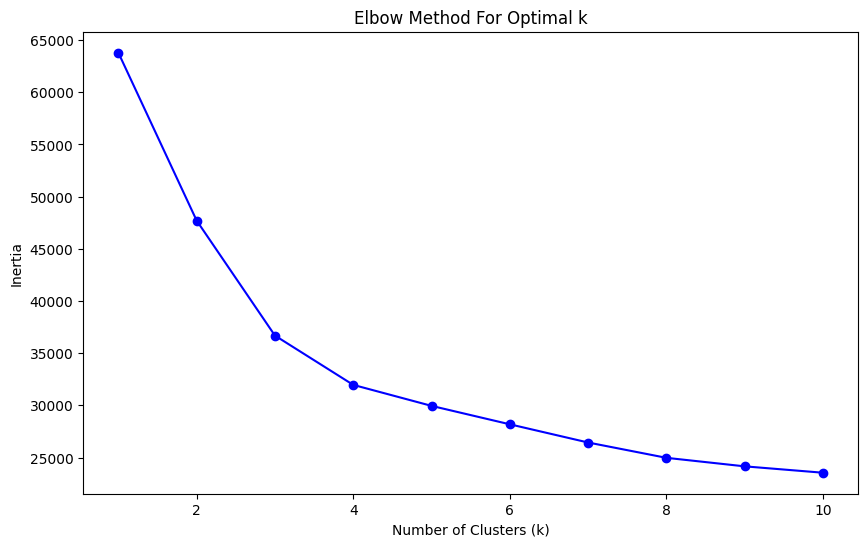

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [61]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_features)

In [62]:
df_original['Cluster'] = cluster_labels
print(f"Successfully clustered customers into {optimal_k} groups.")
display(df_original[['customerID', 'Contract', 'MonthlyCharges', 'Churn', 'Cluster']].head())

Successfully clustered customers into 3 groups.


,customerID,Contract,MonthlyCharges,Churn,Cluster
0,7590-VHVEG,Month-to-month,29.85,No,2
1,5575-GNVDE,One year,56.95,No,2
2,3668-QPYBK,Month-to-month,53.85,Yes,2
3,7795-CFOCW,One year,42.30,No,2
4,9237-HQITU,Month-to-month,70.70,Yes,2


In [63]:
cluster_analysis = df_original.groupby('Cluster').agg({
    'MonthlyCharges': 'mean',
    'tenure': 'mean',
    'Churn': lambda x: x.value_counts(normalize=True).get('Yes', 0) * 100,  
    'Contract': lambda x: x.mode().iloc[0],  
    'InternetService': lambda x: x.mode().iloc[0],  
    'customerID': 'count'  
}).rename(columns={
    'customerID': 'ClusterSize', 
    'Churn': 'ChurnRate (%)'
}).reset_index()

print("Cluster Personas:")
display(cluster_analysis)


Cluster Personas:


,Cluster,MonthlyCharges,tenure,ChurnRate (%),Contract,InternetService,ClusterSize
0,0,89.626816,57.815940,15.587847,Two year,Fiber optic,2271
1,1,21.079194,30.547182,7.404980,Two year,No,1526
2,2,67.901186,15.426679,43.191620,Month-to-month,Fiber optic,3246


In [64]:
print(cluster_analysis.columns)


Index(['Cluster', 'MonthlyCharges', 'tenure', 'ChurnRate (%)', 'Contract',
       'InternetService', 'ClusterSize'],
      dtype='object')


In [65]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "<b>Number of Customers per Cluster</b>",
        "<b>Churn Rate per Cluster (%)</b>",
        "<b>Avg. Tenure per Cluster (Months)</b>",
        "<b>Avg. Monthly Charges per Cluster ($)</b>"
    )
)

fig.add_trace(go.Bar(x=cluster_analysis['Cluster'], y=cluster_analysis['ClusterSize'], name='Size'), row=1, col=1)
fig.add_trace(go.Bar(x=cluster_analysis['Cluster'], y=cluster_analysis['ChurnRate (%)'], name='Churn Rate'), row=1, col=2)
fig.add_trace(go.Bar(x=cluster_analysis['Cluster'], y=cluster_analysis['tenure'], name='Tenure'), row=2, col=1)
fig.add_trace(go.Bar(x=cluster_analysis['Cluster'], y=cluster_analysis['MonthlyCharges'], name='Monthly Charges'), row=2, col=2)

fig.update_layout(
    title_text="<b>Analysis of Customer Segments (Cluster Personas)</b>",
    title_x=0.5,
    showlegend=False,
    height=800
)

fig.show()

In [69]:
from sklearn.decomposition import PCA
import plotly.express as px

persona_map = {
    0: 'Loyal Power Users',
    1: 'Stable, Low-Revenue Customers',
    2: 'High-Risk, High-Churn Customers'
}

df_original['Persona'] = df_original['Cluster'].map(persona_map)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Persona'] = df_original['Persona']
pca_df['Churn'] = df_processed['Churn'].map({0: 'No', 1: 'Yes'})

color_map = {
    'Loyal Power Users': '#00CC96',                
    'High-Risk, High-Churn Customers': '#EF553B',  
    'Stable, Low-Revenue Customers': '#636EFA'     
}

fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='Persona', 
    color_discrete_map=color_map, 
    title='<b>Customer Segments Visualized with PCA</b>',
    hover_data=['Churn']
)

fig.update_layout(
    title_x=0.5,
    width=900,
    height=700,
    legend_title_text='Customer Persona' 
)

fig.show()

## Cluster 0: The "Loyal Power Users"
This is your most valuable and stable high-revenue customer segment.

* **Characteristics:**
    * **High Revenue:** They have the highest average monthly charges ($94.55).
    * **Extremely Loyal:** They have a very high average tenure (61 months) and an incredibly low churn rate (5.8%).
    * **Committed:** Their most common contract type is 'Two year', and they primarily use the premium 'Fiber optic' service.
* **Business Action:** These are your ideal customers. The goal is to keep them happy and potentially upsell them on any new premium services. Avoid targeting them with aggressive price changes.

---
## Cluster 1: The "Stable, Low-Revenue Customers"
This segment is extremely loyal but doesn't generate much revenue. They are a low-risk, stable foundation for the business.

* **Characteristics:**
    * **Low Revenue:** They have the lowest average monthly charges ($21.05).
    * **Most Loyal:** They have the absolute lowest churn rate (2.9%) and a solid average tenure (39 months).
    * **Low Tech:** Their most common contract is 'Two year', but they are defined by having 'No' internet service, meaning they are likely phone-only customers.
* **Business Action:** The opportunity here is to increase their value. Target this group with special, low-cost introductory offers to upgrade to a 'Basic DSL' internet plan.

---
## Cluster 2: The "High-Risk, High-Churn Customers"
This is your largest and most problematic segment. They are new, pay a decent amount, but leave at an alarming rate.

* **Characteristics:**
    * **High Churn:** They have an extremely high churn rate of 54.5%—more than half of these customers leave.
    * **Newer Customers:** They have a very low average tenure (18.9 months).
    * **Flexible Contracts:** Their dominant contract type is 'Month-to-month', which makes it easy for them to leave.
    * **High-Speed Seekers:** They use 'Fiber optic' internet, suggesting they are drawn to the high-speed service but are not willing to commit long-term, possibly due to price.
* **Business Action:** This is the group that needs immediate attention to reduce overall company churn. Target them with campaigns designed to convert them from 'Month-to-month' to a 'One year' contract, perhaps by offering a significant first-year discount.